In [1]:
import os
from os.path import join

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

from shapely.geometry import Polygon, Point
import numpy as np
import xarray as xr
from joblib import Parallel, delayed

from tqdm.notebook import tqdm

from torch.utils.data import Dataset, DataLoader

import torch
import torch.nn as nn

from torchvision.models import efficientnet_b0
import geopandas as gpd

import matplotlib.pyplot as plt

device = "cuda"

In [2]:
f_path = "/home/vannsh.jani/brick_kilns/githubrepo/ML/model_50_no_ssl_features_imagenet.pth"
c_path = "/home/vannsh.jani/brick_kilns/githubrepo/ML/model_50_no_ssl_classifier_imagenet.pth"

model = efficientnet_b0(pretrained=False)
model.classifier = nn.Linear(1280,2)
model.features.load_state_dict(torch.load(f_path))
model.classifier.load_state_dict(torch.load(c_path))
model.to(device)
model.eval();

/home/rishabh.mondal/miniconda3/envs/torch_space/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rishabh.mondal/miniconda3/envs/torch_space/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [3]:
gdf = gpd.read_file("/home/rishabh.mondal/Brick-Kilns-project/albk/experiments/data_preperation/shapefiles/statewise/DISTRICT_BOUNDARY.shp")
gdf.columns
gdf['District'] = gdf['District'].str.replace('>', 'A')
gdf['District'] = gdf['District'].str.replace('<', 'A')
gdf['STATE'] = gdf['STATE'].str.replace('>', 'A') 
gdf['STATE'] = gdf['STATE'].str.replace('<', 'A')
# state_gdf = gdf[gdf['STATE'] == 'BIHAR']
state_gdf = gdf[gdf['STATE'] == 'UTTAR PRADESH']
# delhi_gdf = gdf[gdf['STATE'] == 'PUNJAB']
state_gdf.head(50)

In [4]:
# gdf.head(50)

,District,STATE,REMARKS,State_LGD,DISTRICT_L,Shape_Leng,Shape_Area,geometry
13,AGRA,UTTAR PRADESH,None,9,118,787929.478603,3.902791e+09,"POLYGON ((3823318.714 4371451.435, 3823399.254..."
16,AL|GARH,UTTAR PRADESH,None,9,119,498779.443328,3.585997e+09,"POLYGON ((3792035.575 4455366.311, 3792139.285..."
21,AMBEDKARNAGAR,UTTAR PRADESH,None,9,121,384817.943754,2.242461e+09,"POLYGON ((4244093.138 4288731.854, 4244148.548..."
22,AMETHI,UTTAR PRADESH,None,9,640,396742.737994,2.336052e+09,"POLYGON ((4154715.142 4289236.170, 4155257.456..."
23,AMROHA,UTTAR PRADESH,None,9,154,364954.379714,2.379925e+09,"POLYGON ((3871324.808 4560362.064, 3871398.718..."
29,AURAIYA,UTTAR PRADESH,None,9,122,279215.510357,1.944745e+09,"POLYGON ((3939246.652 4319354.068, 3939361.372..."
30,AZAMGARH,UTTAR PRADESH,None,9,123,498671.919852,4.057542e+09,"POLYGON ((4286924.163 4264884.966, 4287385.646..."
31,BUDAUN,UTTAR PRADESH,None,9,133,449698.119253,4.112357e+09,"POLYGON ((3892522.532 4486653.948, 3892622.992..."
34,BAGHPAT,UTTAR PRADESH,None,9,124,218392.986381,1.281800e+09,"POLYGON ((3728186.204 4578755.701, 3728277.953..."
35,BAHRAICH,UTTAR PRADESH,None,9,125,578747.615415,4.776946e+09,"POLYGON ((4113776.583 4475298.537, 4114099.185..."


<Axes: >

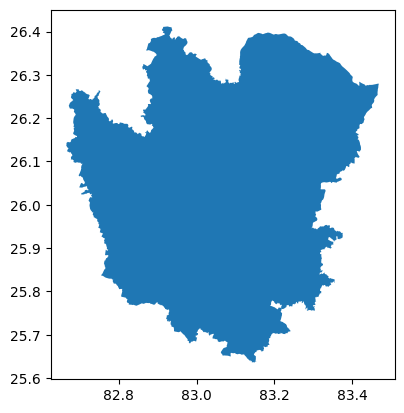

In [6]:
district = "AZAMGARH".upper()
custom_gdf = gdf[gdf["District"] == district]
state_gdf = state_gdf.to_crs(epsg=4326)
custom_gdf = custom_gdf.to_crs(epsg=4326)

custom_gdf.plot()
# state_gdf.plot()

In [7]:
# custom_gdf=state_gdf
## All pairs within the district
lon_min, lat_min, lon_max, lat_max = custom_gdf.geometry.unary_union.bounds

union = custom_gdf.geometry.unary_union
# print(union)
pairs = []
for lat in tqdm(np.arange(lat_min-0.02, lat_max+0.02, 0.01),desc="Latitude progress"):
    for lon in (np.arange(lon_min-0.02, lon_max+0.02, 0.01)):
        # check if the point is within the district
        point = Point(lon, lat)
        if union.contains(point):
            pairs.append((lon, lat))
            
len(pairs)

Latitude progress:   0%|          | 0/82 [00:00<?, ?it/s]

3806

In [8]:
# process pairs
proessed_pairs = []
for pair in pairs:
    # format to .2f
    lon, lat = pair
    
    lon = f"{round(lon, 2):.2f}"
    lat = f"{round(lat, 2):.2f}"
    proessed_pairs.append(f"{lat},{lon}.zarr")

In [9]:
len(proessed_pairs)

3806

In [10]:
# os.listdir("/home/jaiswalsuraj/bkdb/india/bihar/")

In [11]:
os.listdir("/home/jaiswalsuraj/bkdb/india/")
# os.listdir("/home/rishabh.mondal/bkdb/statewise/up")

['up', 'lucknow', 'punjab', 'bihar', 'haryana']

In [12]:
# data_path = "/home/jaiswalsuraj/bkdb/india/haryana/"
# data_path = "/home/jaiswalsuraj/bkdb/india/bihar/"
data_path = '/home/rishabh.mondal/bkdb/statewise/up'
available_files = []
non_available_files = []
for pair in tqdm(proessed_pairs):
    if os.path.exists(join(data_path, pair)):
        available_files.append(join(data_path, pair))
    else:
        non_available_files.append(join(data_path, pair))
print(f"Available: {len(available_files)}")
print(f"Non-Available: {len(non_available_files)}")

  0%|          | 0/3806 [00:00<?, ?it/s]

Available: 3806
Non-Available: 0


In [13]:
print(available_files[1391])
xr.open_zarr(available_files[1391], consolidated=False)

/home/rishabh.mondal/bkdb/statewise/up/25.98,82.82.zarr


<xarray.Dataset>
Dimensions:  (channel: 3, col: 224, lat_lag: 5, lon_lag: 5, row: 224)
Coordinates:
  * channel  (channel) uint8 0 1 2
  * col      (col) uint8 0 1 2 3 4 5 6 7 8 ... 216 217 218 219 220 221 222 223
    lat      float64 ...
  * lat_lag  (lat_lag) int8 -2 -1 0 1 2
    lon      float64 ...
  * lon_lag  (lon_lag) int8 -2 -1 0 1 2
  * row      (row) uint8 0 1 2 3 4 5 6 7 8 ... 216 217 218 219 220 221 222 223
Data variables:
    data     (lat_lag, lon_lag, row, col, channel) uint8 ...
    label    (lat_lag, lon_lag) int8 ...

In [14]:
# import xarray as xr
# import torch
# from joblib import Parallel, delayed
# from tqdm import tqdm

# def process_file(file):
#     with open(file) as f:
#         data = xr.open_zarr(f, consolidated=False)
#     img_list = []
#     idx_list = []
#     for lat_lag in range(-2, 3):
#         for lon_lag in range(-2, 3):
#             img = data["data"].sel(lat_lag=lat_lag, lon_lag=lon_lag).values
#             lat = data["lat"].values.item()
#             lon = data["lon"].values.item()
#             idx = f"{lat:.2f},{lon:.2f}_{lat_lag}_{lon_lag}"
#             img = torch.tensor(img) / 255.0
#             img = torch.einsum("hwc -> chw", img)
#             img_list.append(img)
#             idx_list.append(idx)
#     return torch.stack(img_list), idx_list

# results = Parallel(n_jobs=48)(delayed(process_file)(file) for file in tqdm(available_files))


In [16]:
img_list = []
idx_list = []

def process_file(file):
    try:
        data = xr.open_zarr(file, consolidated=False)
        img_list = []
        idx_list = []
        for lat_lag in range(-2, 3):
            for lon_lag in range(-2, 3):
                img = data["data"].sel(lat_lag=lat_lag, lon_lag=lon_lag).values
                lat = data["lat"].values.item()
                lon = data["lon"].values.item()
                idx = f"{lat:.2f},{lon:.2f}_{lat_lag}_{lon_lag}"
                img = torch.tensor(img) / 255.0
                img = torch.einsum("hwc -> chw", img)
                img_list.append(img)
                idx_list.append(idx)
        return torch.stack(img_list), idx_list
    except KeyError as e:
        print(f"Skipping file {file} due to KeyError: {e}")
        return None

# Your list of files
# available_files = [...]

# Parallel processing with error handling
results = Parallel(n_jobs=48)(delayed(process_file)(file) for file in tqdm(available_files) if process_file(file) is not None)

  0%|          | 0/3806 [00:00<?, ?it/s]

Skipping file /home/rishabh.mondal/bkdb/statewise/up/26.09,83.29.zarr due to KeyError: "No variable named 'lat'. Variables on the dataset include ['data']"
Skipping file /home/rishabh.mondal/bkdb/statewise/up/26.09,83.32.zarr due to KeyError: "No variable named 'lat'. Variables on the dataset include ['data', 'lon_lag']"


In [ ]:
# img_list = []
# idx_list = []
# def process_file(file):
#     data = xr.open_zarr(file, consolidated=False)
#     img_list = []
#     idx_list = []
#     for lat_lag in range(-2, 3):
#         for lon_lag in range(-2, 3):
#             img = data["data"].sel(lat_lag=lat_lag, lon_lag=lon_lag).values
#             lat = data["lat"].values.item()
#             lon = data["lon"].values.item()
#             idx = f"{lat:.2f},{lon:.2f}_{lat_lag}_{lon_lag}"
#             img = torch.tensor(img) / 255.0
#             # print(img.shape)
#             img = torch.einsum("hwc -> chw", img)
#             img_list.append(img)
#             idx_list.append(idx)
#     return torch.stack(img_list), idx_list

# results = Parallel(n_jobs=48)(delayed(process_file)(file) for file in tqdm(available_files))

In [17]:
all_images = torch.cat([result[0] for result in results], dim=0)
mean = all_images.mean(dim=(0, 2, 3), keepdims=True)
std = all_images.std(dim=(0, 2, 3), keepdims=True)
all_images = (all_images - mean) / std
all_idx = [idx for result in results for idx in result[1]]
print(all_images.shape, len(all_idx))

torch.Size([95100, 3, 224, 224]) 95100


In [18]:
batch_size = 512
all_preds = []

for i in tqdm(range(0, len(all_images), batch_size)):
    batch = all_images[i:i+batch_size].to(device)
    with torch.no_grad():
        preds = model(batch).argmax(dim=1).cpu()
    all_preds.append(preds)

all_preds = torch.cat(all_preds, dim=0)

  0%|          | 0/186 [00:00<?, ?it/s]

In [19]:
pred_positive_idx = (all_preds == 1)
print(pred_positive_idx.sum())

locs = np.array(all_idx)[pred_positive_idx]
# print(locs);

tensor(254)


In [20]:
print(pred_positive_idx)

tensor([False, False, False,  ..., False, False, False])


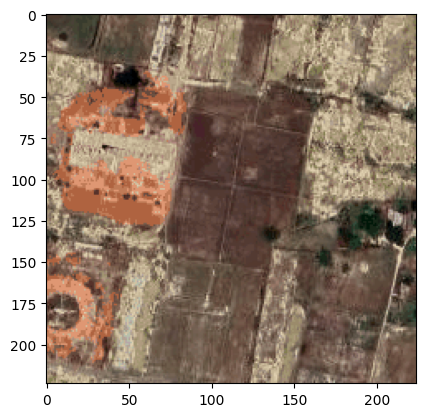

In [21]:
file_name, lags = locs[3].split("_", 1)
lat_lag, lon_lag = lags.split("_")
plt.imshow(xr.open_zarr(join(data_path, file_name+".zarr"), consolidated=False).sel(lat_lag=int(lat_lag), lon_lag=int(lon_lag))['data'].values)

In [22]:
from skimage import img_as_ubyte


In [23]:
len(all_images)
len(all_idx)

95100

In [26]:
# rescaled_images = (all_images * std) + mean
all_images_numpy = rescaled_images.cpu().numpy()

save_path = "/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/predicted_positive/UTTAR_Pradesh/AZAMGARH/"

os.makedirs(save_path, exist_ok=True)
for i, img in tqdm(enumerate(all_images_numpy[pred_positive_idx])):
    img_normalized = img / img.max()
    img = img_as_ubyte(img_normalized)
    plt.imsave(join(save_path, f"{locs[i]}.png"), np.moveaxis(img, 0, -1))

0it [00:00, ?it/s]

In [ ]:
import os

path = "/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/predicted_positive/UTTAR_Pradesh/lucknow"

files = os.listdir(path)
file_names = []

for file in files:
    file_path = os.path.join(path, file)
    if os.path.isfile(file_path):
        file_names.append(file)

print(file_names)
file_list=[file.split('_')[:-2] for file in file_names]
print(file_list)


['26.77,80.98_-2_1.png', '26.86,80.87_-2_0.png', '26.96,80.87_-1_2.png', '27.02,80.92_-2_0.png', '26.77,81.17_-2_2.png', '26.52,81.04_1_-1.png', '26.62,81.10_-2_-1.png', '26.77,81.17_-1_1.png', '26.69,81.06_0_-2.png', '26.68,80.84_-1_1.png', '26.69,81.07_-2_-2.png', '26.72,80.91_-2_1.png', '26.69,80.85_-2_2.png', '26.72,81.15_-2_-1.png', '26.75,81.02_2_2.png', '26.71,81.17_1_-2.png', '26.77,80.89_2_1.png', '27.06,80.92_2_0.png', '26.71,81.17_0_0.png', '26.71,81.05_-1_2.png', '26.71,81.21_0_1.png', '26.95,80.88_-2_0.png', '26.54,81.06_0_0.png', '26.69,81.06_1_1.png', '26.96,80.88_2_1.png', '26.83,81.06_2_0.png', '26.90,81.03_1_1.png', '26.74,81.15_0_0.png', '26.81,81.02_-2_0.png', '26.73,81.16_-1_2.png', '26.69,80.81_1_1.png', '26.95,80.87_-2_2.png', '26.74,81.16_0_-1.png', '26.97,81.01_-2_2.png', '26.81,81.01_-1_0.png', '26.69,80.86_-2_-2.png', '27.02,80.91_-2_1.png', '26.63,81.15_-2_-2.png', '26.69,81.06_-2_-1.png', '26.90,81.04_2_-1.png', '26.68,80.85_-2_-1.png', '27.03,80.95_-1_-2.p

[(26.77, 80.98), (26.86, 80.87), (26.96, 80.87), (27.02, 80.92), (26.77, 81.17), (26.52, 81.04), (26.62, 81.1), (26.77, 81.17), (26.69, 81.06), (26.68, 80.84), (26.69, 81.07), (26.72, 80.91), (26.69, 80.85), (26.72, 81.15), (26.75, 81.02), (26.71, 81.17), (26.77, 80.89), (27.06, 80.92), (26.71, 81.17), (26.71, 81.05), (26.71, 81.21), (26.95, 80.88), (26.54, 81.06), (26.69, 81.06), (26.96, 80.88), (26.83, 81.06), (26.9, 81.03), (26.74, 81.15), (26.81, 81.02), (26.73, 81.16), (26.69, 80.81), (26.95, 80.87), (26.74, 81.16), (26.97, 81.01), (26.81, 81.01), (26.69, 80.86), (27.02, 80.91), (26.63, 81.15), (26.69, 81.06), (26.9, 81.04), (26.68, 80.85), (27.03, 80.95), (26.95, 80.9), (26.65, 80.9), (27.13, 80.93), (26.93, 81.03), (26.54, 81.04), (26.77, 81.17), (27.03, 80.91), (26.71, 81.16), (26.7, 81.19), (26.6, 81.05), (27.02, 80.92), (26.69, 80.84), (26.59, 81.0), (27.12, 80.88), (26.72, 81.16), (26.71, 81.2), (26.67, 80.95), (26.77, 81.01), (26.72, 81.19), (26.71, 81.19), (26.65, 80.99), 

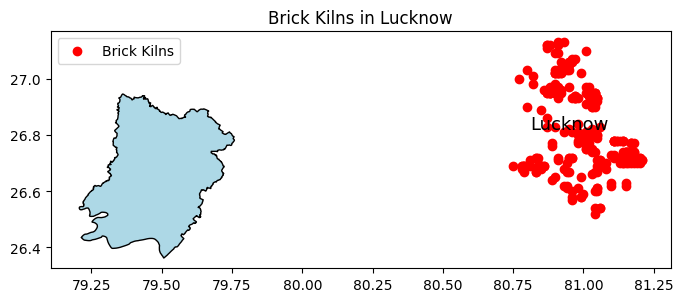

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Your list of coordinates
coordinates = file_list
# Extracting latitude and longitude from the coordinates list
points = [(float(coord[0].split(',')[0]), float(coord[0].split(',')[1])) for coord in coordinates]
print(points)
# Create a GeoDataFrame for the points
points_gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy([point[1] for point in points], [point[0] for point in points]))
print(points_gdf)
# Plotting the custom_gdf
ax = custom_gdf.plot(color='lightblue', edgecolor='black', figsize=(8, 8))

# Plotting the points on the same plot
points_gdf.plot(ax=ax, color='red', marker='o',label='Brick Kilns')
ax.text(80.95, 26.82, 'Lucknow', color='black', fontsize=13, ha='center')
plt.legend()
plt.title('Brick Kilns in Lucknow')

# Display the plot
plt.show()

